In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import pandas_datareader as web

In [5]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime.now()
df = web.DataReader('AAPL','yahoo', start, end)

In [6]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,30.478571,30.080000,30.447144,30.104286,88102700.0,26.272409
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.681330
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.727465
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.302330
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.253704


In [8]:
mvavg = df['Adj Close'].rolling(window=100).mean()

/Volumes/stuff/siraj_course/week2/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


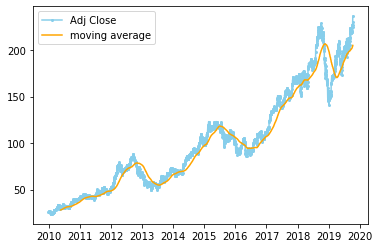

In [9]:
plt.plot(df.index,df['Adj Close'], marker='o',markersize=2, color='skyblue',label='Adj Close')
plt.plot(df.index ,mvavg, marker='', color='orange',label='moving average')
plt.legend()

In [10]:
df2 = df.loc[:,['Volume','Adj Close']]

In [11]:
df2['HL_PCT'] = ((df.High - df.Low)/df.Close)*100
df2['PCT_Change'] = ((df.Close - df.Open)/df.Open)*100


In [12]:
forecast_out = int(.01*len(df2))

In [13]:
df2['Label'] = df2['Adj Close'].shift(-forecast_out)

In [14]:
X = df2.drop('Label',1)
X = preprocessing.scale(X)
X_forecast = X[-forecast_out:]
X = X[:-forecast_out]
y = df2['Label']
y = np.array(y[:-forecast_out])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [16]:
# Linear Regression
cls_lin_reg = LinearRegression()
cls_lin_reg.fit(X_train, y_train)

#Quadratic Regression
cls_quad2_reg = make_pipeline(PolynomialFeatures(2), Ridge())
cls_quad2_reg.fit(X_train, y_train)

#Quadratic Regression
cls_quad3_reg = make_pipeline(PolynomialFeatures(3), Ridge())
cls_quad3_reg.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [17]:
cls_lasso_reg = LassoCV(eps=0.002, n_alphas=100)
cls_lasso_reg.fit(X_train, y_train)

/Volumes/stuff/siraj_course/week2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.002, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [18]:
scores = {}
scores['Linear'] = cls_lin_reg.score(X_test, y_test)
scores['Poly2'] = cls_quad2_reg.score(X_test, y_test)
scores['Poly3'] = cls_quad3_reg.score(X_test, y_test)
scores['Lasso'] = cls_lasso_reg.score(X_test, y_test)

In [19]:
scores

{'Linear': 0.9699502085152437,
 'Poly2': 0.9708239604924075,
 'Poly3': 0.9710651185564133,
 'Lasso': 0.9700379141006523}

In [20]:
forecast_set = cls_lasso_reg.predict(X_forecast)
df2['Forecast'] = np.nan

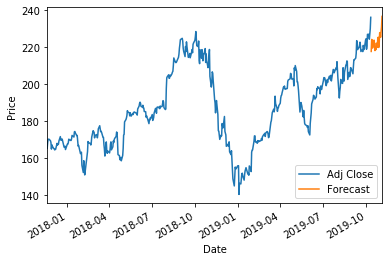

In [21]:
last_date = df2.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df2.loc[next_date] = [np.nan for _ in range(len(df2.columns)-1)]+[i]
df2['Adj Close'].tail(500).plot()
df2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()